In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import set_neutral_position
import ndiff
import pandas as pd
from imp import reload
jtplot.style()
%matplotlib inline

ppm_routines = ndiff.ppm_routines

In [2]:
# Some simple functions to set up the and perform the neutral diffusion flux calculations
def ppm_reconstruction(h, Slayer):    
    Sinterface = np.zeros(np.size(Slayer)+1, dtype=np.float32)
    ppm_routines.interface_scalar(h, Slayer, Sinterface, 2)
    Sl = np.zeros(np.size(Slayer), dtype=np.float32)
    Sr = np.zeros(np.size(Slayer), dtype=np.float32)
    ppm_routines.ppm_left_right_edge_values(Slayer.astype(np.float32), Sinterface, Sl, Sr)
    return Sl, Sr

def construct_column(h, T):
    zi = np.array(0) ; zi = np.append(zi,hl.cumsum())
    z_t = h.cumsum() - h[0]
    z_b = h.cumsum()
    z_c = h.cumsum() - 0.5*h
    T_t, T_b = ppm_reconstruction(h,T)
    
    return zi, z_t, z_b, z_c, T_t, T_b

def interp_reconstruction(T_t, T_c, T_b, P, k):
    if P == 0.:
        return T_t[k]
    if P == 1.:
        return T_b[k]
    elif P>0. and P<1.:
        T_int = np.interp( P, np.array( (0., 0.5, 1.) ), np.array( (T_t[k], T_c[k], T_b[k]) ) )
        return T_int
    else:
        print(k, P)

def plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                          zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL, search_dir):
    # Plot PPM reconstructon of left column
    for k in np.arange(0,hl.size):
        z = np.array( [zl_t[k], zl_c[k], zl_b[k]])
        T = np.array( [Tl_t[k], Tl[k], Tl_b[k]] )
        plt.plot(T,z, color='green')
        plt.scatter(Tl_t, zl_t, marker='^')
        plt.scatter(Tl_b, zl_b, marker='v')
    # PPM reconstruction of right column 
    for k in np.arange(0,hl.size):
        z = np.array( [zr_t[k], zr_c[k], zr_b[k]] )
        T = np.array( [Tr_t[k], Tr[k], Tr_b[k]] )
        plt.plot(T,z, color = 'cyan')
        plt.scatter(Tr_t, zr_t, marker='^')
        plt.scatter(Tr_b, zr_b, marker='v')    
    
    # Plot neutral surfaces
    for k in np.arange(0,PoR_abs.size):
        kr = KoR[k]
        Tr_int = interp_reconstruction(Tr_t, Tr, Tr_b, PoR[k], kr)
        kl = KoL[k]
        Tl_int = interp_reconstruction(Tl_t, Tl, Tl_b, PoL[k], kl)
        if search_dir[k] == 0:
            #plt.plot(np.array( (Tl_int, Tr_int) ), np.array( (PoL_abs[k],PoR_abs[k]) ) , ':', color="green" ) 
            plt.arrow( Tl_int, PoL_abs[k], Tr_int - Tl_int , PoR_abs[k] - PoL_abs[k], head_width=0.5, color="green" ) 
        else:
            plt.arrow( Tr_int, PoR_abs[k], Tl_int - Tr_int , PoL_abs[k] - PoR_abs[k], head_width=0.5, color="cyan" )
            #plt.plot(np.array( (Tl_int, Tr_int) ), np.array( (PoL_abs[k],PoR_abs[k]) ) , ':', color="cyan" ) 
        print("Surface %d:" % k, Tl_int, Tr_int, PoL_abs[k], PoR_abs[k])
    plt.xlim( (5,22.5) )
    plt.grid(ls='dotted')
    plt.xlabel('Temperature')
    plt.gca().invert_yaxis()    
        

# Overview
This notebook and accompanying code mimics how MOM6 finds the neutral surfaces along which to perform parameterized diffusion. The examples in here are based on Alistair Adcrofts schematics where density is controlled by temperature with $\frac{d\rho}{dT} = -1$. Unlike his original slides, in this notebook, a discontinuous reconstruction of temperature is done

In [3]:
# Set up some examples based on Alistair's schematics of
nk = 4
Sl_t = np.zeros(nk) ; Sl_b = np.zeros(nk)
Sr_t = np.zeros(nk) ; Sr_b = np.zeros(nk)
drdt_lt = -1*np.ones(nk) ; drdt_lb = -1*np.ones(nk)
drds_lt = np.zeros(nk) ; drds_lb = np.zeros(nk)
drdt_rt = -1*np.ones(nk) ; drdt_rb = -1*np.ones(nk)
drds_rt = np.zeros(nk) ; drds_rb = np.zeros(nk)

# Identical columns


Working on k_surface 0: Tl[0,0]: 20.000000 Tr[0,0]: 20.000000
Searching left layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Position on left : 0.000000
Position on right: 0.000000

Working on k_surface 1: Tl[0,0]: 20.000000 Tr[0,1]: 20.000000
Searching right layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Unstratified, point top
Position on left : 0.000000
Position on right: 0.000000
[  0.  10.  20.  30.  40.] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
hL: 0.000000 hR: 0.000000 hEff: 0.000000

Working on k_surface 2: Tl[0,1]: 20.000000 Tr[0,1]: 20.000000
Searching left layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Unstratified, point bottom
Position on left : 1.000000
Position on right: 1.000000
[  0.  10.  20.  30.  40.] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
hL: 10.000000 hR: 10.000000 hEff: 10.000000

Working on k_surface 3: Tl[0,1]: 20.000000 Tr[1,0]: 18.666666
Searching right layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Position on left : 1.000000
Position on right: 0.000000
[  0.  10.  20.  30.  40

/home/ashao/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ashao/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


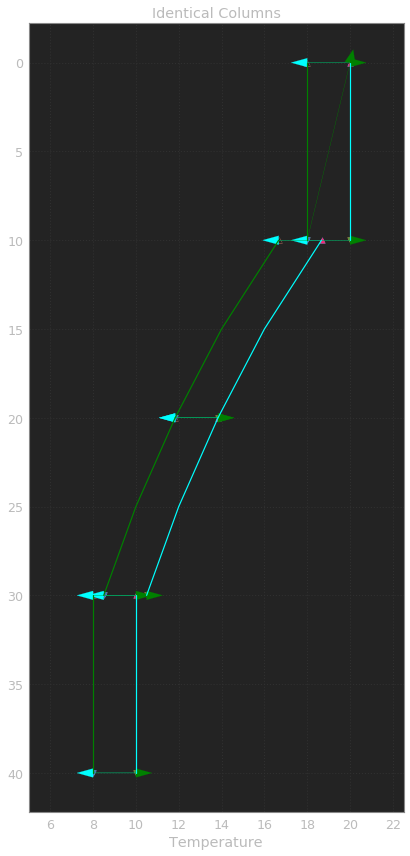

In [138]:
# Warmer on right
reload(set_neutral_position)
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([20.,16.,12.,10.])
Tl = np.array([20.,16.,12.,10.])
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR, search_dir = set_neutral_position.set_neutral_surface_position2(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_identical = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t-2, Tl-2, Tl_b-2, PoL_abs, KoL, search_dir)
plt.title('Identical Columns')
print(hEff.sum())

In [130]:
print(df_identical)

    KoL  KoR  PoL  PoR    hL    hR    zl    zr
0     1    1  0.0  0.0   0.0   0.0   0.0   0.0
1     1    1  0.0  0.0   0.0   0.0   0.0   0.0
2     1    1  1.0  1.0  10.0  10.0  10.0  10.0
3     1    1  1.0  1.0   0.0   0.0  10.0  10.0
4     2    2  0.0  0.0   0.0   0.0  10.0  10.0
5     2    2  0.0  0.0   0.0   0.0  10.0  10.0
6     2    2  1.0  1.0  10.0  10.0  20.0  20.0
7     2    2  1.0  1.0   0.0   0.0  20.0  20.0
8     3    3  0.0  0.0   0.0   0.0  20.0  20.0
9     3    3  0.0  0.0   0.0   0.0  20.0  20.0
10    3    3  1.0  1.0  10.0  10.0  30.0  30.0
11    3    3  1.0  1.0   0.0   0.0  30.0  30.0
12    4    4  0.0  0.0   0.0   0.0  30.0  30.0
13    4    4  0.0  0.0   0.0   0.0  30.0  30.0
14    4    4  1.0  1.0  10.0  10.0  40.0  40.0
15    4    4  1.0  1.0   0.0   0.0  40.0  40.0


# Right column is slightly warmer


Working on k_surface 0: Tl[0,0]: 18.000000 Tr[0,0]: 20.000000
Searching left layer 0: dRhoTop: 2.000000 dRhoBot: 2.000000
Position on left : 0.000000
Position on right: 0.000000

Working on k_surface 1: Tl[0,0]: 18.000000 Tr[0,1]: 20.000000
Searching left layer 0: dRhoTop: 2.000000 dRhoBot: 2.000000
Position on left : 0.000000
Position on right: 1.000000
[  0.  10.  20.  30.  40.] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
hL: 0.000000 hR: 10.000000 hEff: 0.000000

Working on k_surface 2: Tl[0,0]: 18.000000 Tr[1,0]: 18.666666
Searching left layer 0: dRhoTop: 0.666666 dRhoBot: 0.666666
Position on left : 0.000000
Position on right: 0.000000
[  0.  10.  20.  30.  40.] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
hL: 0.000000 hR: 0.000000 hEff: 0.000000

Working on k_surface 3: Tl[0,0]: 18.000000 Tr[1,1]: 13.833333
Searching right layer 0: dRhoTop: -2.000000 dRhoBot: -2.000000
Unstratified, point top
Position on left : 0.000000
Position on right: 0.000000
[  0.  10.  20.  30.  40.] [0 0 0 0 0 0 0 0 0 0 0 0 

/home/ashao/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ashao/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


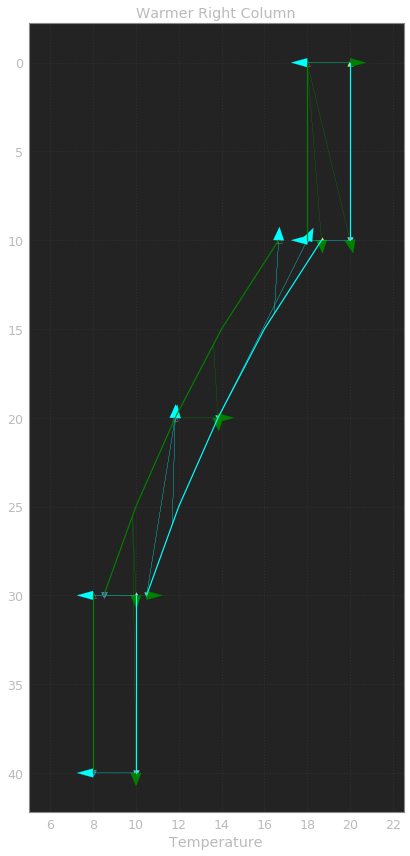

In [4]:
# Warmer on right
reload(set_neutral_position)
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([20.,16.,12.,10.])
Tl = np.array([18.,14.,10.,8.])
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR, search_dir = set_neutral_position.set_neutral_surface_position2(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_warm_right = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL, search_dir)
plt.title('Warmer Right Column')
print(hEff.sum())
print(df_warm_right)

In [132]:
reload(ndiff)
Sl_t = np.zeros(hl.size) ; Sl_b = np.zeros(hl.size)
Sr_t = np.zeros(hl.size) ; Sr_b = np.zeros(hl.size)
drdt_lt = -1*np.ones(hl.size) ; drdt_lb = -1*np.ones(hl.size)
drds_lt = np.zeros(hl.size) ; drds_lb = np.zeros(hl.size)
drdt_rt = -1*np.ones(hl.size) ; drdt_rb = -1*np.ones(hl.size)
drds_rt = np.zeros(hl.size) ; drds_rb = np.zeros(hl.size)
PoL = np.zeros(4*hl.size, dtype=np.float32) ; PoR = np.zeros(4*hl.size, dtype=np.float32)
KoL = np.zeros(4*hl.size, dtype=np.int32) ; KoR = np.zeros(4*hl.size, dtype=np.int32)
hEff = np.zeros(4*hl.size - 1, dtype=np.float32)

ndiff.ppm_routines.find_neutral_surface_positions_discontinuous(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb,
    PoL, PoR, KoL, KoR, hEff)

# Left Column is warmer

     Pl   Sl         Tl  dRdS_l  dRdT_l
0   0.0  0.0  20.000000     0.0    -1.0
1  10.0  0.0  20.000000     0.0    -1.0
2  10.0  0.0  18.666666     0.0    -1.0
3  20.0  0.0  13.833333     0.0    -1.0
4  20.0  0.0  13.833333     0.0    -1.0
5  30.0  0.0  10.500000     0.0    -1.0
6  30.0  0.0  10.000000     0.0    -1.0
7  40.0  0.0  10.000000     0.0    -1.0
     Pr   Sr         Tr  dRdS_r  dRdT_r
0   0.0  0.0  18.000000     0.0    -1.0
1  10.0  0.0  18.000000     0.0    -1.0
2  10.0  0.0  16.666666     0.0    -1.0
3  20.0  0.0  11.833333     0.0    -1.0
4  20.0  0.0  11.833333     0.0    -1.0
5  30.0  0.0   8.500000     0.0    -1.0
6  30.0  0.0   8.000000     0.0    -1.0
7  40.0  0.0   8.000000     0.0    -1.0

Working on k_surface 0: dRho: 2.000000 Tl[0]: 20.000000 Tr[0]: 18.000000
Searching right: dRhoTop: 2.000000 dRhoBot: 2.000000
krm1: 0 kr: 0 kl: 0
At surface
Position on left : 0.000000
Position on right: 0.000000

Working on k_surface 1: dRho: 2.000000 Tl[1]: 20.000000 Tr[0]: 18

/home/ashao/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ashao/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


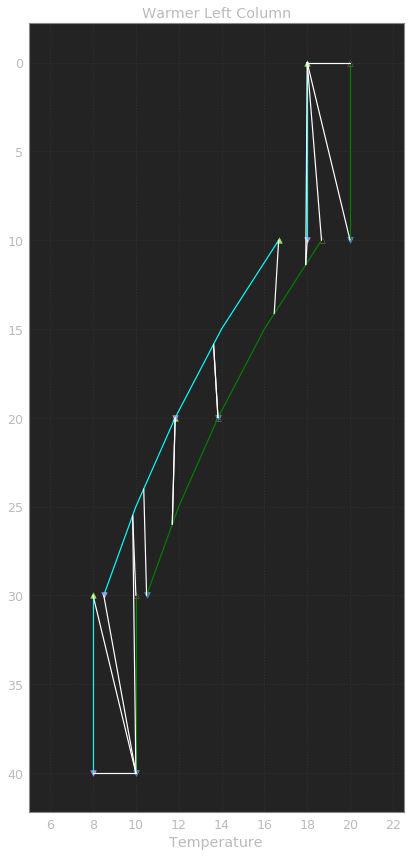

In [68]:
# Warmer on right
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([18.,14.,10.,8.])
Tl = np.array([20.,16.,12.,10.])
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR = set_neutral_position.set_neutral_surface_position(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_warm_left = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL)
plt.title('Warmer Left Column')
print(hEff.sum())

# Much Cooler on right

     Pl   Sl         Tl  dRdS_l  dRdT_l
0   0.0  0.0  20.000000     0.0    -1.0
1  10.0  0.0  20.000000     0.0    -1.0
2  10.0  0.0  18.666666     0.0    -1.0
3  20.0  0.0  14.000000     0.0    -1.0
4  20.0  0.0  14.000000     0.0    -1.0
5  30.0  0.0   9.333333     0.0    -1.0
6  30.0  0.0   8.000000     0.0    -1.0
7  40.0  0.0   8.000000     0.0    -1.0
     Pr   Sr        Tr  dRdS_r  dRdT_r
0   0.0  0.0  8.000000     0.0    -1.0
1  10.0  0.0  8.000000     0.0    -1.0
2  10.0  0.0  6.666667     0.0    -1.0
3  20.0  0.0  2.000000     0.0    -1.0
4  20.0  0.0  2.000000     0.0    -1.0
5  30.0  0.0 -2.666667     0.0    -1.0
6  30.0  0.0 -4.000000     0.0    -1.0
7  40.0  0.0 -4.000000     0.0    -1.0

Working on k_surface 0: dRho: 12.000000 Tl[0]: 20.000000 Tr[0]: 8.000000
Searching right: dRhoTop: 12.000000 dRhoBot: 12.000000
krm1: 0 kr: 0 kl: 0
At surface
Position on left : 0.000000
Position on right: 0.000000

Working on k_surface 1: dRho: 12.000000 Tl[1]: 20.000000 Tr[0]: 8.000000

/home/ashao/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ashao/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


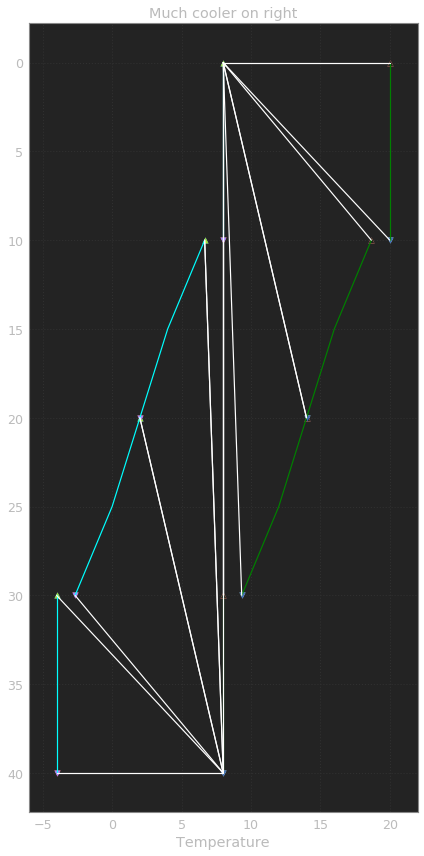

In [80]:
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([8., 4., 0., -4.])
Tl = np.array([20., 16., 12.,8.])
Sl_t = np.zeros(hl.size) ; Sl_b = np.zeros(hl.size)
Sr_t = np.zeros(hl.size) ; Sr_b = np.zeros(hl.size)
drdt_lt = -1*np.ones(hl.size) ; drdt_lb = -1*np.ones(hl.size)
drds_lt = np.zeros(hl.size) ; drds_lb = np.zeros(hl.size)
drdt_rt = -1*np.ones(hl.size) ; drdt_rb = -1*np.ones(hl.size)
drds_rt = np.zeros(hl.size) ; drds_rb = np.zeros(hl.size)
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR = set_neutral_position.set_neutral_surface_position(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_cool_right = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL)
plt.xlim((-6,22))
plt.title('Much cooler on right')
print(df_cool_right)
print(hEff.sum())